# Label and Chip SAR Data

### This notebook will utilize Wildland Fire Interagency Geospatial Services (WFIGS) perimeter data to determine the extent of the wildfires present in the SAR images. Then it will chip the images into smaller tiles for training.

To replicate this notebook, you need to download GeoJSON file from https://data-nifc.opendata.arcgis.com/datasets/7c81ab78d8464e5c9771e49b64e834e9_0/explore?showTable=true

In [17]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform
from rasterio.features import geometry_mask
from shapely.geometry import box, Polygon
from matplotlib_scalebar.scalebar import ScaleBar
import warnings

### Load in Wildfire Perimeter Data

In [2]:
# Gather data into GeoDataFrame
data_path = '~/FIREMAPS/Data/'
data_file = 'WFIGS_Interagency_Perimeters_YearToDate_7244446855919551728.geojson'
file_path = data_path + data_file

wfigs_data = gpd.read_file(file_path)
wfigs_data['poly_IncidentName'] = wfigs_data['poly_IncidentName'].astype(str).str.lower()

# list from https://en.wikipedia.org/wiki/January_2025_Southern_California_wildfires
fires_wanted = ['palisades', 'eaton', 'bert', 'hurst', 'lidia', 'sunset', 'sunswept', 'kenneth', 'hughes']

wfigs_la = wfigs_data[wfigs_data['poly_IncidentName'].isin(fires_wanted)]
wfigs_la

,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_DeleteThis,poly_FeatureAccess,poly_FeatureStatus,poly_IsVisible,...,attr_CreatedOnDateTime_dt,attr_ModifiedOnDateTime_dt,attr_Source,attr_IsCpxChild,attr_CpxName,attr_CpxID,attr_SourceGlobalID,GlobalID,attr_IncidentComplexityLevel,geometry
17,36398,172,palisades,Wildfire Daily Fire Perimeter,IR Image Interpretation,23448.000000,No,Public,Approved,Yes,...,"Tue, 07 Jan 2025 19:23:56 GMT","Sat, 01 Feb 2025 01:45:24 GMT",IRWIN,0.0,None,None,{35C19D7C-FEDA-42F8-AD76-9B094E783801},2a11c9e3-3295-4623-8c53-4e9a192ae0f3,Type 3 Incident,"MULTIPOLYGON (((-118.56093 34.04408, -118.5609..."
20,36410,615,eaton,Wildfire Daily Fire Perimeter,Mixed Methods,14021.108712,No,Public,Approved,Yes,...,"Wed, 08 Jan 2025 02:22:48 GMT","Wed, 05 Mar 2025 17:44:11 GMT",IRWIN,0.0,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},52bfca63-1058-40fe-a4b8-ec17b36361c1,Type 4 Incident,"MULTIPOLYGON (((-118.08301 34.23769, -118.0830..."
22,36411,312,hurst,Wildfire Daily Fire Perimeter,Mixed Methods,799.817638,No,Public,Approved,Yes,...,"Wed, 08 Jan 2025 06:53:19 GMT","Fri, 17 Jan 2025 01:20:08 GMT",IRWIN,0.0,None,None,{D69D1FE4-0B5E-43AF-89FF-BD4757EF0DFA},a54b079e-9b60-497f-bbb6-672f21184aa0,Type 3 Incident,"POLYGON ((-118.47458 34.34255, -118.47434 34.3..."
28,36421,266,kenneth,Wildfire Daily Fire Perimeter,IR Image Interpretation,998.737772,No,Public,Approved,Yes,...,"Thu, 09 Jan 2025 22:55:01 GMT","Sun, 12 Jan 2025 13:47:07 GMT",IRWIN,0.0,None,None,{99DAB162-D90A-44E4-9326-756A20C336B4},441e30cb-a3f3-4b71-8518-7025a19d821f,Type 3 Incident,"POLYGON ((-118.67692 34.16894, -118.6769 34.16..."
60,36658,912,hughes,Wildfire Daily Fire Perimeter,IR Image Interpretation,10425.343367,No,Public,Approved,Yes,...,"Wed, 22 Jan 2025 18:43:27 GMT","Wed, 05 Mar 2025 17:43:43 GMT",IRWIN,0.0,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},34bbdfd9-eec4-4c10-8e82-294091e86685,Type 3 Incident,"MULTIPOLYGON (((-118.58018 34.53925, -118.5811..."


Text(0.5, 1.0, 'LA Wildfires, January 2025')

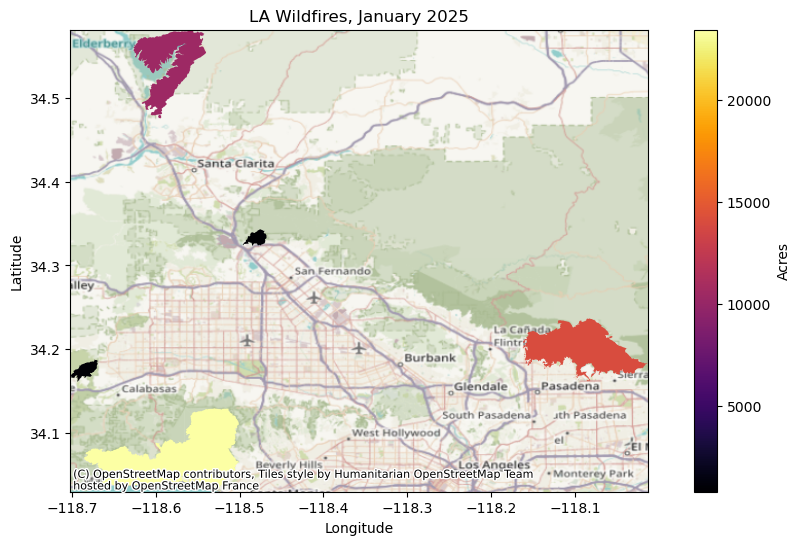

In [3]:
# Plot LA wildfires Jan 2025
f, ax = plt.subplots(figsize=(12,6))

wfigs_la.plot(ax = ax, column = 'poly_GISAcres', cmap = 'inferno', legend = True,
                     legend_kwds = {'label': 'Acres'}, markersize = 2)
ctx.add_basemap(ax, crs=wfigs_la.crs) #, source = ctx.providers.OpenTopoMap)
ax.set_xlim(wfigs_la.total_bounds[0], wfigs_la.total_bounds[2])
ax.set_ylim(wfigs_la.total_bounds[1], wfigs_la.total_bounds[3])

ax.set_aspect('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('LA Wildfires, January 2025')

### Load in SAR Images

In [4]:
local_directory = os.path.expanduser('~/FIREMAPS/Data/Wildfires/')
tif_files = [f for f in os.listdir(local_directory) if f.endswith('.tif')]

if tif_files:
    print("Downloaded tif files:")
    for file in tif_files:
        print(file)
else:
    print("No tif files found in the directory.")

Downloaded tif files:
CAPELLA_C09_SP_GEO_HH_20250112071930_20250112071936.tif
CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952.tif
CAPELLA_C10_SS_GEO_HH_20250113021051_20250113021104.tif
CAPELLA_C11_SP_GEO_HH_20250112202415_20250112202441.tif
CAPELLA_C13_SM_GEO_HH_20250115210818_20250115210823.tif
CAPELLA_C13_SM_GEO_HH_20250116125106_20250116125111.tif
CAPELLA_C13_SM_GEO_HH_20250118200502_20250118200506.tif
CAPELLA_C13_SM_GEO_HH_20250119114748_20250119114753.tif
CAPELLA_C13_SM_GEO_HH_20250119183651_20250119183655.tif
CAPELLA_C14_SS_GEO_HH_20250111145546_20250111145602.tif
CAPELLA_C14_SS_GEO_HH_20250111163649_20250111163705.tif
CAPELLA_C14_SS_GEO_HH_20250112081445_20250112081501.tif
CAPELLA_C15_SS_GEO_HH_20250111190504_20250111190518.tif
CAPELLA_C15_SS_GEO_HH_20250112055128_20250112055142.tif
CAPELLA_C15_SS_GEO_HH_20250112191305_20250112191319.tif


In [12]:
# Choose SAR image to work with (one at a time!)
#tif_name = 'CAPELLA_C09_SP_GEO_HH_20250112071930_20250112071936.tif' # no fires
tif_name = 'CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952.tif' # 3 fires
#tif_name = 'CAPELLA_C10_SS_GEO_HH_20250113021051_20250113021104.tif'
#tif_name = 'CAPELLA_C11_SP_GEO_HH_20250112202415_20250112202441.tif'
#tif_name = 'CAPELLA_C13_SM_GEO_HH_20250115210818_20250115210823.tif'
#tif_name = 'CAPELLA_C13_SM_GEO_HH_20250116125106_20250116125111.tif'
#tif_name = 'CAPELLA_C13_SM_GEO_HH_20250118200502_20250118200506.tif'
#tif_name = 'CAPELLA_C13_SM_GEO_HH_20250119114748_20250119114753.tif'
#tif_name = 'CAPELLA_C13_SM_GEO_HH_20250119183651_20250119183655.tif'
#tif_name = 'CAPELLA_C14_SS_GEO_HH_20250111145546_20250111145602.tif'
#tif_name = 'CAPELLA_C14_SS_GEO_HH_20250111163649_20250111163705.tif'
#tif_name = 'CAPELLA_C14_SS_GEO_HH_20250112081445_20250112081501.tif'
#tif_name = 'CAPELLA_C15_SS_GEO_HH_20250111190504_20250111190518.tif'
#tif_name = 'CAPELLA_C15_SS_GEO_HH_20250112055128_20250112055142.tif'
#tif_name = 'CAPELLA_C15_SS_GEO_HH_20250112191305_20250112191319.tif'

# setup I/O
tif_file = os.path.join(local_directory, tif_name) 
tif_basename = os.path.splitext(os.path.basename(tif_file))[0]

# read file
with rasterio.open(tif_file) as src:
    # downsample SAR (optional - do this if code/plots are taking too long)
    down_factor = 1  
    new_height = src.height // down_factor
    new_width = src.width // down_factor

    # read SAR data
    img_data = src.read(
        1,  
        out_shape=(new_height, new_width), 
        resampling=Resampling.average 
    )
    
    # set up transform for later
    transform = src.transform * src.transform.scale(
        (src.width / new_width),  
        (src.height / new_height)
    )
    
    # get SAR CRS
    crs = src.crs
    wfigs_la = wfigs_la.to_crs(crs)

    # get SAR bounds
    sar_bounds = src.bounds
    sar_bbox = box(sar_bounds.left, sar_bounds.bottom, sar_bounds.right, sar_bounds.top)
    
print(f'file read in: {tif_basename}')

file read in: CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952


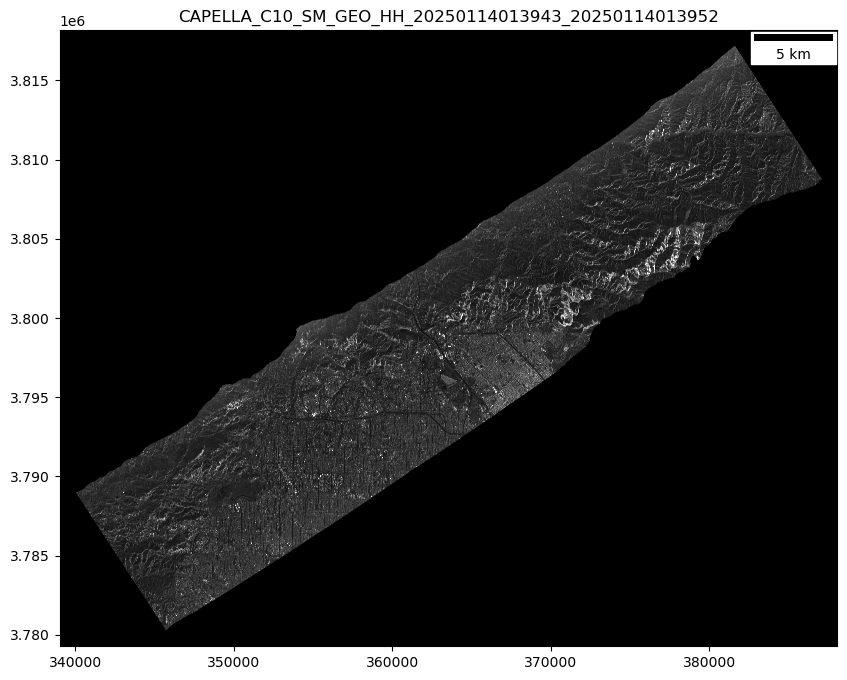

In [13]:
# Plot raw SAR image
f, ax = plt.subplots(figsize=(12, 8))
ax.imshow(img_data, cmap='gray', extent=(sar_bounds.left, sar_bounds.right, sar_bounds.bottom, sar_bounds.top),
          vmin=0, vmax=3000) 
                # ^^^^ consider changing vmax here if you are having trouble seeing details in the image
                # if image is too dark, lower vmax. if image is too bright, raise vmax.
ax.set_title(f'{tif_basename}')
ax.set_xlim(sar_bounds.left, sar_bounds.right)
ax.set_ylim(sar_bounds.bottom, sar_bounds.top)
ax.set_aspect('equal')
ax.add_artist(ScaleBar(1))
plt.show()

### Find overlapping geometry

Number of overlapping fire perimeters: 3
Overlapping fire(s): ['hurst' 'kenneth' 'hughes']


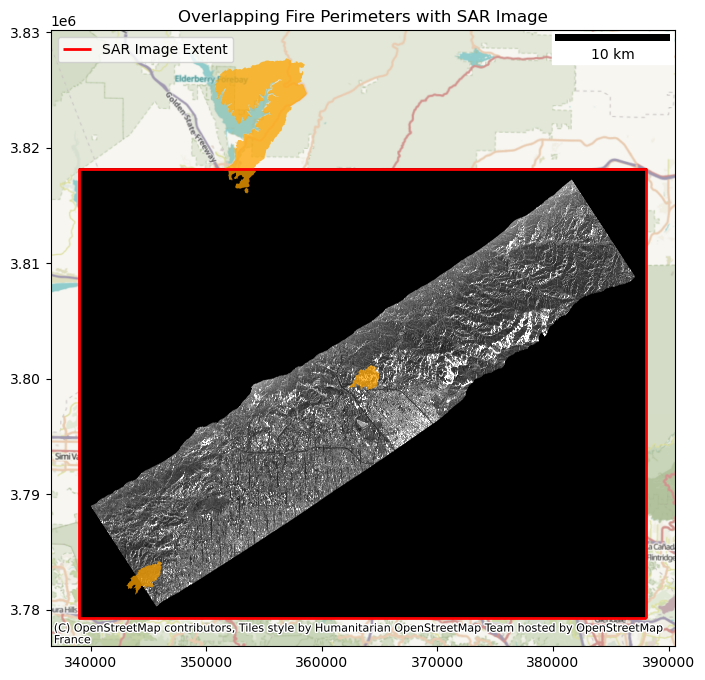

In [14]:
# Create gdf from SAR geometry
sar_gdf = gpd.GeoDataFrame({'geometry': [sar_bbox]}, crs=wfigs_la.crs)
overlapping_fires = wfigs_la[wfigs_la.intersects(sar_bbox)]

print(f"Number of overlapping fire perimeters: {len(overlapping_fires)}")
print(f"Overlapping fire(s): {overlapping_fires['poly_IncidentName'].values}")  

# plot!
f, ax = plt.subplots(figsize=(12, 8))
sar_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label="SAR Image Extent")
overlapping_fires.plot(ax=ax, alpha=0.75, color='orange')
ctx.add_basemap(ax, crs=wfigs_la.crs)
ax.imshow(img_data, cmap='gray', extent=(sar_bounds.left, sar_bounds.right, sar_bounds.bottom, sar_bounds.top),
          vmin=0, vmax=1500)
ax.set_title('Overlapping Fire Perimeters with SAR Image')
ax.legend(loc = 'upper left')
ax.add_artist(ScaleBar(1))
plt.show()

In [15]:
# find overlaps and output to geojson
overlapping_polygons = []
output_json_dir = os.path.expanduser('~/FIREMAPS/Data/GeoJSON/')

# add intersections between fires and SAR extent
for _, row in wfigs_la.iterrows():
    fire_polygon = row.geometry  
    intersection = sar_bbox.intersection(fire_polygon)

    if not intersection.is_empty:
        overlapping_polygons.append(intersection)

if overlapping_polygons:
    overlapping_gdf = gpd.GeoDataFrame(geometry=overlapping_polygons, crs=wfigs_la.crs)
    
    output_geojson = os.path.join(output_json_dir, f"{tif_basename}_fire_overlap.geojson")
    os.makedirs(output_json_dir, exist_ok=True)
    overlapping_gdf.to_file(output_geojson, driver="GeoJSON")
    print(f"Overlapping regions saved to {output_geojson}")
else:
    print("No overlapping regions found.")

Overlapping regions saved to C:\Users\Owner/FIREMAPS/Data/GeoJSON/CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952_fire_overlap.geojson


### Create mask for overlapping fire regions

Boundary mask saved to C:\Users\Owner/FIREMAPS/Data/GeoJSON/CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952_boundary_mask.tif


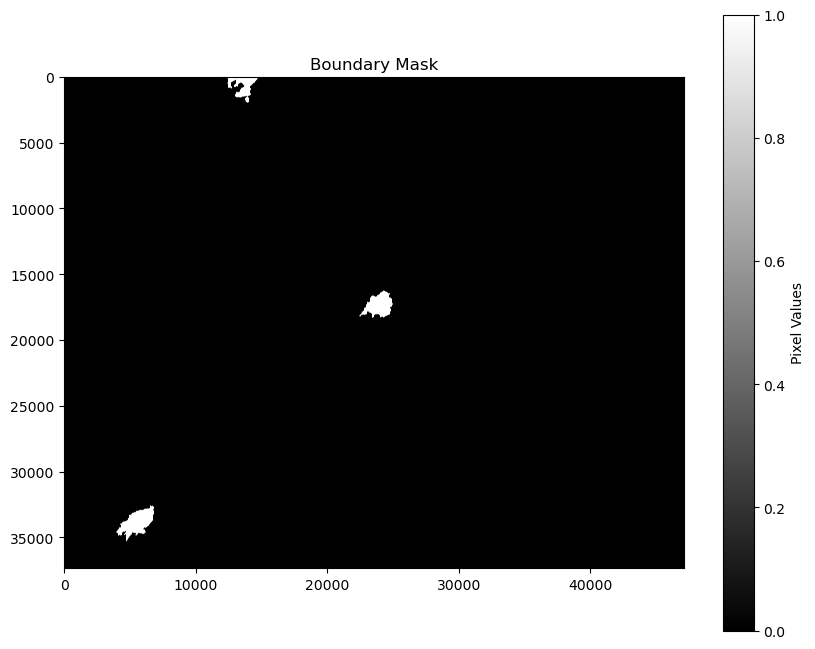

In [18]:
# init mask
mask = np.zeros((new_height, new_width), dtype=np.uint8)

# fill mask
warnings.simplefilter("ignore", DeprecationWarning) # turn off depreciation warning
with rasterio.open(tif_file) as src:
    fire_boundaries = overlapping_gdf.geometry.unary_union 
    boundary_mask = geometry_mask([fire_boundaries], transform=transform, invert=True,
                                  out_shape=(new_height, new_width))
    mask[boundary_mask] = 1

# save mask as tif
output_mask_file = os.path.join(output_json_dir, f"{tif_basename}_boundary_mask.tif")
with rasterio.open(output_mask_file, 'w', driver='GTiff', height=new_height, width=new_width,
                   count=1, dtype='uint8', crs=crs, transform=transform) as dst:
    dst.write(mask, 1)
print(f"Boundary mask saved to {output_mask_file}")

# plot mask for reasonability check (should match red region in plot above!)
with rasterio.open(output_mask_file) as src:
    image = src.read(1)  
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap='gray')
    plt.colorbar(label="Pixel Values")
    plt.title("Boundary Mask")
    plt.show()

### Chip SAR images (and matching mask)

In [19]:
# create NxN tiles by chipping SAR image
# ENTER TILE SIZE HERE: 
tile_size = 1024

# I/O
tif_filepath = '~/FIREMAPS/Data/Wildfires/' + tif_name
tif_file = os.path.expanduser(tif_filepath)
tif_basename = os.path.splitext(os.path.basename(tif_file))[0]
tif_dir = os.path.dirname(tif_file)
output_dir = os.path.join(tif_dir, tif_basename)
output_tif_dir = os.path.join(output_dir, "tiles_tif")
output_mask_dir = os.path.join(output_dir, "tiles_masks")
os.makedirs(output_tif_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# loop to create tiles
rows, cols = img_data.shape
tile_idx = 0
for i in range(0, rows, tile_size):     # start in top left corner
    for j in range(0, cols, tile_size): # start in top left corner
        tile = img_data[i:i+tile_size, j:j+tile_size]  

        if tile.shape == (tile_size, tile_size): # make sure that tile created above is square as intented
            non_zero_pixels = np.count_nonzero(tile)
            total_pixels = tile.size
            non_zero_ratio = non_zero_pixels / total_pixels
            if non_zero_ratio >= 0.75:  # Save only if 75% or more of the tile is non-zero - eliminates most empty space tiles
                vmax = np.percentile(tile, 95) # find vmax to ensure images are more readable (eliminate high outliers!)
                
                # use transform from above
                tile_scaled = np.clip(tile, 0, vmax)
                tile_transform = from_origin(
                    transform.c + j * transform.a,  
                    transform.f - i * transform.e,  
                    transform.a, transform.e
                )
                
                # save tif
                tif_filename = os.path.join(output_tif_dir, f"tile_{tile_idx}.tif")
                with rasterio.open(
                    tif_filename, 'w', 
                    driver='GTiff',
                    height=tile_size,
                    width=tile_size,
                    count=1,
                    dtype=tile_scaled.dtype,
                    crs=src.crs,
                    transform=tile_transform
                ) as dst:
                    dst.write(tile_scaled, 1)
                
                # save mask
                tile_mask = mask[i:i+tile_size, j:j+tile_size]
                mask_filename = os.path.join(output_mask_dir, f"tile_{tile_idx}_mask.tif")
                with rasterio.open(
                    mask_filename, 'w', 
                    driver='GTiff',
                    height=tile_size,
                    width=tile_size,
                    count=1,
                    dtype=tile_mask.dtype,
                    crs=src.crs,
                    transform=tile_transform
                ) as dst_mask:
                    dst_mask.write(tile_mask, 1)
                
                tile_idx += 1

print(f"Saved {tile_idx} tiles and their corresponding masks in {output_dir}")

Saved 420 tiles and their corresponding masks in C:\Users\Owner/FIREMAPS/Data/Wildfires\CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952


### Reasonability check (optional) 

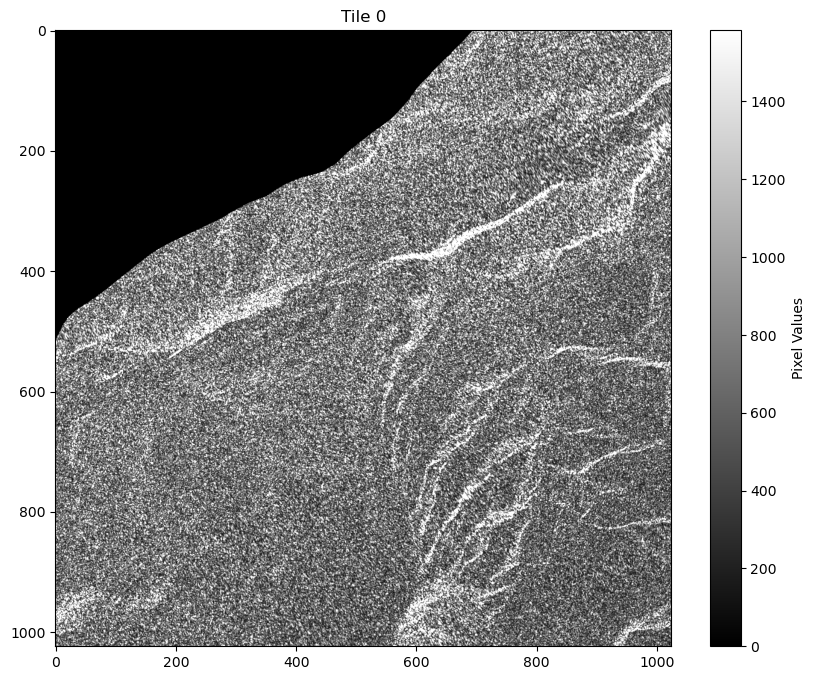

In [27]:
# plot tile to check
tile_idx = 0

filepath_img = r"C:\Users\Owner\FIREMAPS\Data\Wildfires\\" + tif_basename + r"\tiles_tif\tile_" + str(tile_idx) + ".tif"
filepath_msk = r"C:\Users\Owner\FIREMAPS\Data\Wildfires\\" + tif_basename + r"\tiles_masks\tile_" + str(tile_idx) + "_mask.tif"

with rasterio.open(filepath_img) as src: # <<< can also plot mask here
    image = src.read(1)

    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap='gray')
    plt.colorbar(label="Pixel Values")
    plt.title("Tile " + str(tile_idx))
    plt.show()